# Definições iniciais - necessárias para os itens pedidos no trabalho

## Bibliotecas

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays
using DataFrames

## Base linear

In [2]:
# Primeira função da base
function ϕ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

# Segunda função da base
function ϕ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

# Derivada da primeira função da base
function dϕ₁(ξ)
    return -1.0/2.0 :: Float64
end

# Derivada da segunda função da base
function dϕ₂(ξ)
    return 1.0/2.0 :: Float64
end

dϕ₂ (generic function with 1 method)

## Funções auxiliares

In [3]:
# Dado um índice e a quantidade de pontos internos de uma discretização
# retorna o valor de x referente aquele índice (no intervalo [0, 1])
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

# Dado um ξ no elemento padrão, o nó mais à esquerda de um elemento
# e o tamanho de um elemento (h), retorna o x referente ao ξ
function map_ξ_x(ξ, x_i_inf, h)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

function monta_uh(c)    
    return vcat(0, c, 0)
end

monta_uh (generic function with 1 method)

# Itens soliciados no trabalho

## EQ e LG

In [4]:
function monta_LG(ne)
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne)
    m = ne-1
    return vcat(m+1, 1:m, m+1)
end

monta_EQ (generic function with 1 method)

## Cálculo das entradas das matrizes e vetores locais utilizando quadratura gaussiana

In [5]:
function quadratura_F_local(f, ϕ, α, β, γ, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β, γ) * ϕ(ξ)) 
    end
    
    return quad
end
    

function quadratura_phis_K(f1, f2)
    pontos, pesos = legendre(5)
    quad = 0
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f1(ξ) * f2(ξ) ) 
    end
    
    return quad
end

function monta_F_local(f, α, β, γ, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local(f, ϕ₁, α, β, γ, e, m)
    F_local[2] = h/2 * quadratura_F_local(f, ϕ₂, α, β, γ, e, m)

    return F_local    
end

function monta_K_local(α, β, γ, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁) + γ * quadratura_phis_K(ϕ₁, dϕ₁)
    K_local[1, 2] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂) + γ * quadratura_phis_K(ϕ₁, dϕ₂)
    K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₁) + γ * quadratura_phis_K(ϕ₂, dϕ₁)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂) + γ * quadratura_phis_K(ϕ₂, dϕ₂)   
    
    return K_local
end

monta_K_local (generic function with 1 method)

## Montagem da matriz e do vetor global a partir das matrizes e vetores locais

In [6]:
function monta_F_global(f, α, β, γ, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local(f, α, β, γ, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global(α, β, γ, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local(α, β, γ, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

monta_K_global (generic function with 1 method)

## Cálculo do erro na norma L2 utilizando quadratura gaussiana.

In [7]:
function erro_L2(u, α, β, γ, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h), α, β, γ) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

# Entrada fornecida nas instruções do trabalho

In [8]:
α = 1.0
β = 1.0
γ = 1.0
f(x, α, β, γ) = (α*π^2 + β) * sin(π*x) + γ * π * cos(π*x)
u(x, α, β, γ) = sin(π * x)

u (generic function with 1 method)

# Funções para comparação de soluções e estudo de erro

In [9]:
# Dado o número de elementos, α, β, γ, a solução u 
# e a solução uʰ avaliada em alguns pontos plota u e uʰ.
function plot_exact_and_numerical(ne::Int64, α, β, γ, u, sol_on_points)
    m = ne-1
    points = get_point.(0:ne, m)    
    u_on_points = u.((range(0, 1, 100), α, β, γ)...)  
    
    plot(range(0, 1, 100), u_on_points, lw=3, label="Solução Exata")
    display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
end

function solucao_e_teste(α, β, γ, f, u, ne)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global(α, β, γ, ne, EQoLG)
    F = monta_F_global(f, α, β, γ, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, α, β, γ, u, uh)
    
    return
end

function estudo_convergencia(n_testes, f, u, α, β, γ)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global(α, β, γ, ne, EQoLG)
        F = monta_F_global(f, α, β, γ, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, α, β, γ, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

estudo_convergencia (generic function with 1 method)

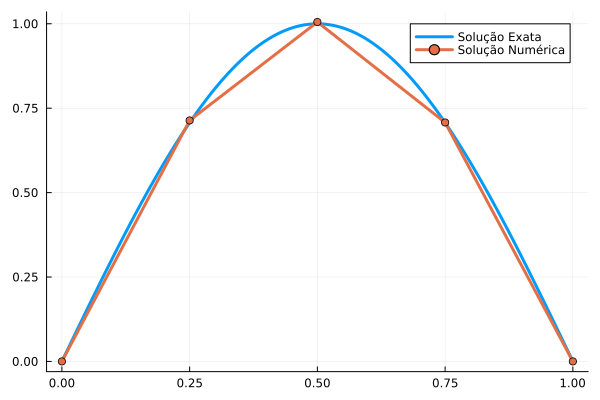

In [10]:
ne = 4
solucao_e_teste(α, β, γ, f, u, ne)

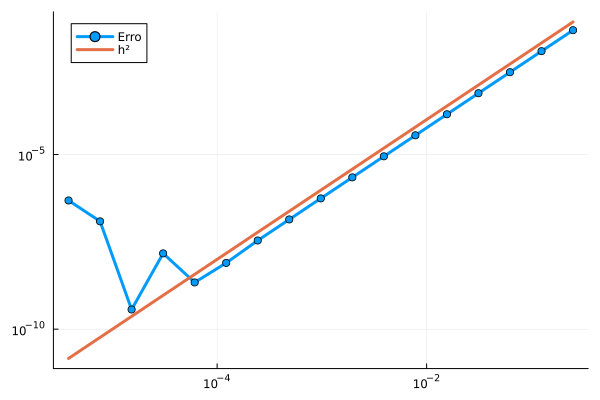

In [11]:
n_testes = 18
estudo_convergencia(n_testes, f, u, α, β, γ)